## Call multiple deep learning frameworks (cellpose cyto3, cellposesam, microsam, and mobilesam) in the same notebook

Currently it is not possible to call cellpose-cyto3 and cellposesam in the same environment.  It is also often a pain to get the different sam approaches all working together in a Napari environment. 

This example based on a example from Ashley Anderson [here](https://gist.github.com/aganders3/baa98b99e9997b0c7ff4cf521bc2ec8e) shows how to use ```multiprocessing.managers.SharedMemoryManager``` to create memory that can be shared between processes.  We then use subprocess to run the two flavors of cellpose in different environments passing the subprocess the name of the shared memory. 

### Limitations

This approach is slow as a new environment is created for each call.  Long term a more performant approach would be based on a fully functional deep learning server running in a separate environment.  Peter Sobolewski suggests looking [here](https://monai.io/label.html), [here](https://github.com/Imaging-Server-Kit/imaging-server-kit?tab=readme-ov-file) and [here](https://github.com/biopb/biopb), and looking at uvicorn, Ian Coccimiglio suggests looking at appose-python [here](https://github.com/apposed/appose-python)

### Dependencies

You will need a environment with microsam and mobilesam.  Then you will need environments with cellposecyto3 and cellposesam.  See ```10_dependencies.md``` for more details on how to set up environments.    


## Imports and image loading

To run you will need change a few local paths and environment names

1.  Image and Label paths should point to a 2D image on your machine (label path can be None if no ground truth)
2.  Parent path (where the figures go) needs to point to a local location
3.  The ```cellpose3``` and ```cellposesam``` environment names need to point to local environments with cyto3 and cpsam. 

cell_00212
Loaded image shape: (2096, 2096, 3), dtype: uint8


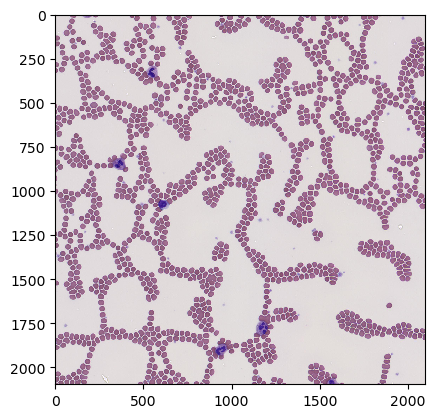

In [86]:
from multiprocessing.managers import SharedMemoryManager
import numpy as np
from skimage import io
import os
import subprocess
import matplotlib.pyplot as plt
from microsam_predictor import microsam_predict
from mobilesam_predictor import mobilesam_predict
from plt_helper import mask_overlay, imshow_multi2d

# Load image using skimage.io.imread


image_path = r"D:\images\tnia-python-images\imagesc\2024_03_27_SOTA_segmentation\images\cell_00081.bmp"
label_path = r"D:\images\tnia-python-images\imagesc\2024_03_27_SOTA_segmentation\labels\cell_00081_label.tiff"



image_path = r"D:\images\tnia-python-images\imagesc\2025_05_10_SOTA_Test_Set\TestHidden_002.tif"
label_path = r"D:\images\tnia-python-images\imagesc\2025_05_10_SOTA_Test_Set\annotations\class_0\TestHidden_002.tif"

image_path = r"D:\images\tnia-python-images\imagesc\2025_05_10_SOTA_Test_Set\TestHidden_157.bmp"
label_path = r"D:\images\tnia-python-images\imagesc\2025_05_10_SOTA_Test_Set\annotations\class_0\TestHidden_157.tif"

image_path = r"D:\images\tnia-python-images\imagesc\2024_03_27_SOTA_segmentation\images\cell_00212.png"
label_path = r"D:\images\tnia-python-images\imagesc\2024_03_27_SOTA_segmentation\labels\cell_00212_label.tiff"

parent_path = r"D:\images\tnia-python-images\imagesc\2025_05_23_many_sams_sm"

cellpose3_env_name='microsam_cellpose'
cellposesam_env_name='microsam_cellose_sam'

figure_path = os.path.join(parent_path, "figures")
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

image_name = os.path.basename(image_path)
image_name = os.path.splitext(image_name)[0]
print(image_name)


img = io.imread(image_path)

if (len(img.shape) == 2):
    img = np.expand_dims(img, axis=2)  # Add channel dimension if it's grayscale
    # repeat channels so there is 3
    img = np.repeat(img, 3, axis=2)

# Print image information
print(f"Loaded image shape: {img.shape}, dtype: {img.dtype}")

plt.imshow(img)

In [100]:
roi = np.s_[512:512+1024, 512:512+1024, ...]

if roi is not None:
    img = img[roi]
    print(f"Image shape after ROI selection: {img.shape}")

Image shape after ROI selection: (1024, 1024, 3)


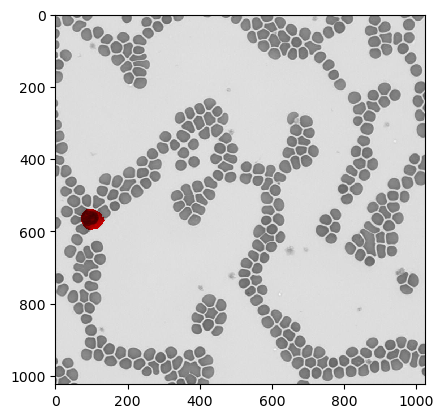

In [101]:
if label_path is not None:
    label = io.imread(label_path)
    if roi is not None:
        label = label[roi]
    overlay_im = mask_overlay(img, label)
    plt.imshow(overlay_im)
    plt.imsave(os.path.join(figure_path, f"{image_name}_overlay.png"), overlay_im)

## Microsam prediction

In [102]:
out_microsam = microsam_predict(img)

Using model type: vit_b_lm


Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


## Mobilesam prediction

In [103]:
try:
    out_mobilesam = mobilesam_predict(img)
except Exception as e:
    out_mobilesam = np.zeros_like(out_microsam)


0: 1024x1024 367 objects, 50.0ms
Speed: 13.0ms preprocess, 50.0ms inference, 5.0ms postprocess per image at shape (1, 3, 1024, 1024)


VIT checkpoint loaded successfully


## Instanseg

In [104]:
help(instanseg_brightfield.eval)

Help on method eval in module instanseg.inference_class:

eval(image: Union[str, List[str]], pixel_size: Optional[float] = None, save_output: bool = False, save_overlay: bool = False, save_geojson: bool = False, processing_method: str = 'auto', **kwargs) -> Union[torch.Tensor, List[torch.Tensor], NoneType] method of instanseg.inference_class.InstanSeg instance
    Evaluate the input image or list of images using the InstanSeg model.
    :param image: The path to the image, or a list of such paths.
    :param pixel_size: The pixel size in microns.
    :param save_output: Controls whether the output is saved to disk (see :func:`save_output <instanseg.Instanseg.save_output>`).
    :param save_overlay: Controls whether the output is saved to disk as an overlay (see :func:`save_output <instanseg.Instanseg.save_output>`).
    :param save_geojson: Controls whether the geojson output labels are saved to disk (see :func:`save_output <instanseg.Instanseg.save_output>`).
    :param processing_met

In [105]:
from instanseg import InstanSeg
instanseg_brightfield = InstanSeg("brightfield_nuclei", image_reader= "tiffslide", verbosity=1)
#result = instanseg_brightfield.eval(img, pixel_size=0.1)
result, image_tensor  = instanseg_brightfield.eval_small_image(img, 0.1)

out_instanseg = np.squeeze(result[0].cpu().numpy().astype('uint16'))

Model brightfield_nuclei version 0.1.0 already downloaded in c:\Users\bnort\miniconda3\envs\microsam_cellpose\Lib\site-packages\instanseg\utils\../bioimageio_models/, loading
Requesting default device: cuda


## Create shared memory manager


In [106]:
smm = SharedMemoryManager(address=('localhost', 8080), authkey=b'secret')
smm.start()
smm.connect()
print('connected to server', smm)

connected to server <multiprocessing.managers.SharedMemoryManager object at 0x0000021AB4EA5DD0>


## Create shared memory for Cellpose input

For Cellpose we want to call version 3 and version 4 (cellposesam).  However to do this we need to call into a separate environment (because cp3 and cp4 can't both be installed)

So first create a shared memory array which we can then read from a subprocess running in a different envronment

In [107]:
# Create shared memory with name
shape = img.shape
dtype = img.dtype
nbytes = np.prod(shape) * np.dtype(dtype).itemsize

# Create the shared memory block
#shm = shared_memory.SharedMemory(create=True, size=int(nbytes), name=name)
shm_input = smm.SharedMemory(size=int(nbytes))
print(shm_input, shm_input.name, shm_input.size)
# Create a numpy array backed by shared memory
shared_array = np.ndarray(shape, dtype=dtype, buffer=shm_input.buf)
# Copy the image data to shared memory
shared_array[:] = img[:]

print(f"Image copied to shared memory. Name: {shm_input.name}, Shape: {shape}")

SharedMemory('wnsm_c423ad77', size=3145728) wnsm_c423ad77 3145728
Image copied to shared memory. Name: wnsm_c423ad77, Shape: (1024, 1024, 3)


## Create Cellpose caller function

This function uses subrocess to call the 'cellpose_predictor' script, passsing in...

- location of conda (will have to change to local location)
- name of environment with cellpose3/4 (will have to change to local name)
- name : name of shared memory for the input
- shape of the data
- out_name : name of shared for the output

In [108]:
def call_cellpose_environment(in_name, out_name, environment_name, dtype):
    print(f"Calling Cellpose with output name: {out_name} in environment: {environment_name}")
    script_path = os.path.abspath("cellpose_predictor.py")
    print("Calling script:", script_path)
    result = subprocess.run([
        "C:/Users/bnort/miniconda3/condabin/conda.bat", "run", "-n", environment_name,
        "python", script_path, in_name, str(shape[0]), str(shape[1]), str(shape[2]), out_name, str(dtype)
    ], capture_output=True, text=True)

    print("Exit code:", result.returncode)
    print("Output:", result.stdout)
    print("Error Message (if nothing that is good):", result.stderr)

## Run cyto3 via a subprocess

First we create shared memory for the output then call ```call_cellpose_environment``` with the cellpose3 environment

In [109]:
shape_out = [shape[0], shape[1]]
nbytes_out = np.prod(shape_out) * np.dtype(np.uint16).itemsize
shm_out_cyto3 = smm.SharedMemory(size=int(nbytes_out))
name_out_cyto3 = shm_out_cyto3.name

In [110]:
print('shape')
print('shape_out', shape_out)
print('nbytes_out', nbytes_out)
call_cellpose_environment(shm_input.name, name_out_cyto3, cellpose3_env_name, dtype)
out_array_cyto3 = np.ndarray(shape_out, dtype=dtype, buffer=shm_out_cyto3.buf)

shape
shape_out [1024, 1024]
nbytes_out 2097152
Calling Cellpose with output name: wnsm_6f35a5e8 in environment: microsam_cellpose
Calling script: c:\Users\bnort\work\ImageJ2022\tnia\tnia-python\notebooks\imagesc\2025_05_21_shared_memory\cellpose_predictor.py
Exit code: 0
Output: shape in (1024, 1024, 3)
Sum of shared memory array: 615169722
Cellpose version: 3.1.0 (major number: 3)
out_name wnsm_6f35a5e8
shape_out [1024, 1024]
nbytes 2097152


Error Message (if nothing that is good): 


# Run cellposesam via a subprocess

Same as above except we pass in an environment name that has cellpose4


In [111]:
shm_out_cpsam = smm.SharedMemory(size=int(nbytes_out))
out_name_cpsam = shm_out_cpsam.name

call_cellpose_environment(shm_input.name, out_name_cpsam, cellposesam_env_name, dtype)
out_array_cpsam = np.ndarray(shape_out, dtype=dtype, buffer=shm_out_cpsam.buf)

Calling Cellpose with output name: wnsm_aa55d14d in environment: microsam_cellose_sam
Calling script: c:\Users\bnort\work\ImageJ2022\tnia\tnia-python\notebooks\imagesc\2025_05_21_shared_memory\cellpose_predictor.py
Exit code: 0
Output: 

Welcome to CellposeSAM, cellpose v4.0.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


shape in (1024, 1024, 3)
Sum of shared memory array: 615169722
Cellpose version: 4.0.1 (major number: 4)
out_name wnsm_aa55d14d
shape_out [1024, 1024]
nbytes 2097152


Error Message (if nothing that is good): 


## Make overlay figure

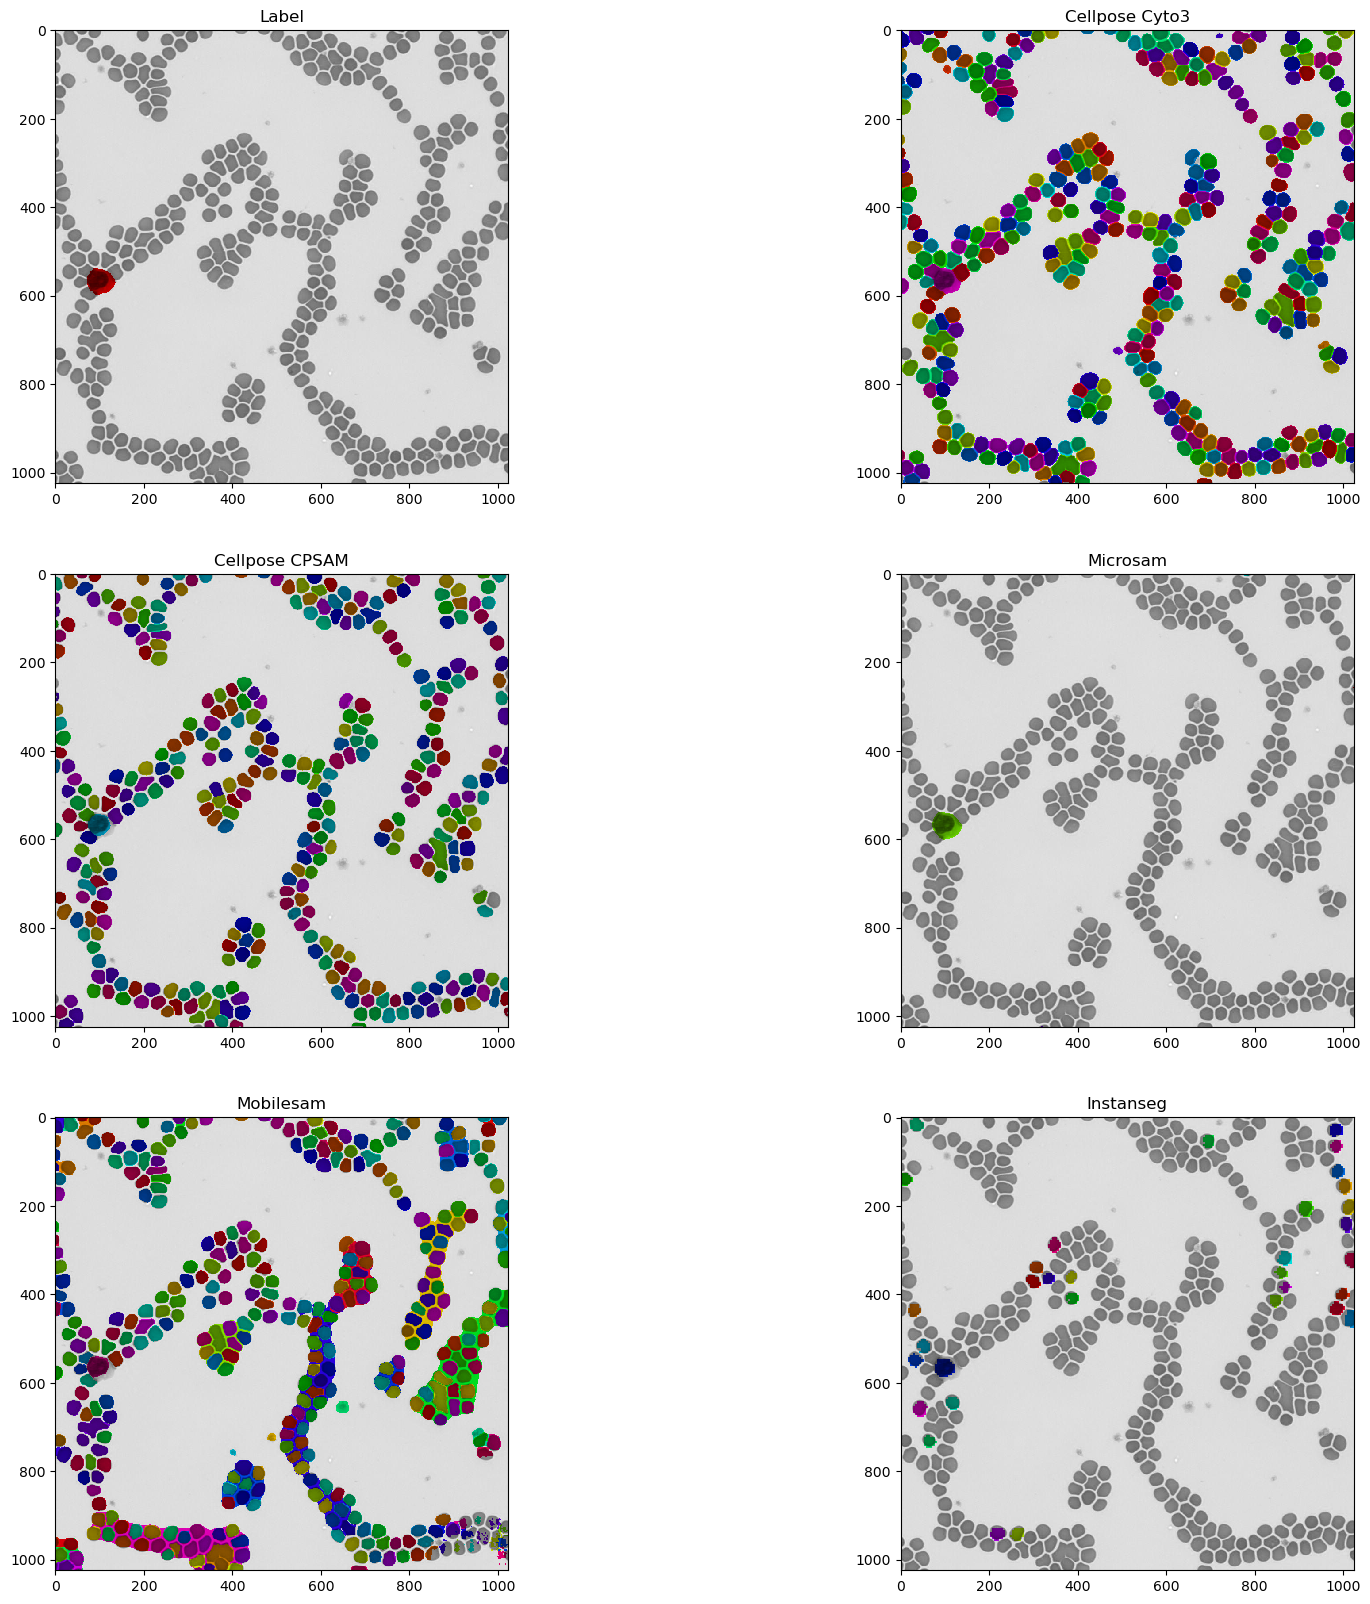

In [112]:
overlay_cyto3 = mask_overlay(img, out_array_cyto3)
overlay_cpsam = mask_overlay(img, out_array_cpsam)
overlay_microsam = mask_overlay(img, out_microsam)
overlay_mobilesam = mask_overlay(img, out_mobilesam)
overlay_instanseg = mask_overlay(img, out_instanseg)

fig = imshow_multi2d([overlay_im, overlay_cyto3, overlay_cpsam, overlay_microsam, overlay_mobilesam, overlay_instanseg], ['Label', 'Cellpose Cyto3', 'Cellpose CPSAM', 'Microsam', 'Mobilesam', 'Instanseg'], 3, 2, width=20, height=20)

fig.savefig(os.path.join(figure_path, f"{image_name}_cellpose_microsam.png"), dpi=300)

In [19]:
import napari
viewer = napari.Viewer()
viewer.add_image(img, name='input')
if label_path is not None:
    viewer.add_labels(label, name='label')
viewer.add_labels(out_array_cyto3, name='cp3')
viewer.add_labels(out_array_cpsam, name='cpsam')
viewer.add_labels(out_microsam, name='microsam')
viewer.add_labels(out_mobilesam, name='mobilesam')

<Labels layer 'mobilesam' at 0x21ad9dba550>

<Labels layer 'cp4 [1]' at 0x2a516fafe50>

: 

In [8]:
print(dtype)

float64
